# OBJECTIVE


We will be building various Machine Learning models and Deep Learning models with different architectures. In the end, we will see how machine learning models perform in comparison to deep learning models.

In [5]:
# Loading Libraries
import pandas as pd

import numpy as np

from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_log_error,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

import datetime

from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import seaborn as sns

from keras.models import Sequential

from keras.layers import Dense

from prettytable import PrettyTable


In [7]:
df=pd.read_csv(r"C:\Users\OWNER\Desktop\VICTOR\machine learning\ml prj\car_price_prediction.csv")
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


#  Data Inspection


In this section, we will explore the data. First Let’s see what columns we have in the data and their data types along with missing values information

In [8]:
df.shape

(19237, 18)

In [9]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
ID,19237.0,4.557654e+07,936591.422799,20746880.0,45698374.0,45772308.0,45802036.0,45816654.0
Price,19237.0,1.855593e+04,190581.269684,1.0,5331.0,13172.0,22075.0,26307500.0
Prod. year,19237.0,2.010913e+03,5.668673,1939.0,2009.0,2012.0,2015.0,2020.0
Cylinders,19237.0,4.582991e+00,1.199933,1.0,4.0,4.0,4.0,16.0
Airbags,19237.0,6.582627e+00,4.320168,0.0,4.0,6.0,12.0,16.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

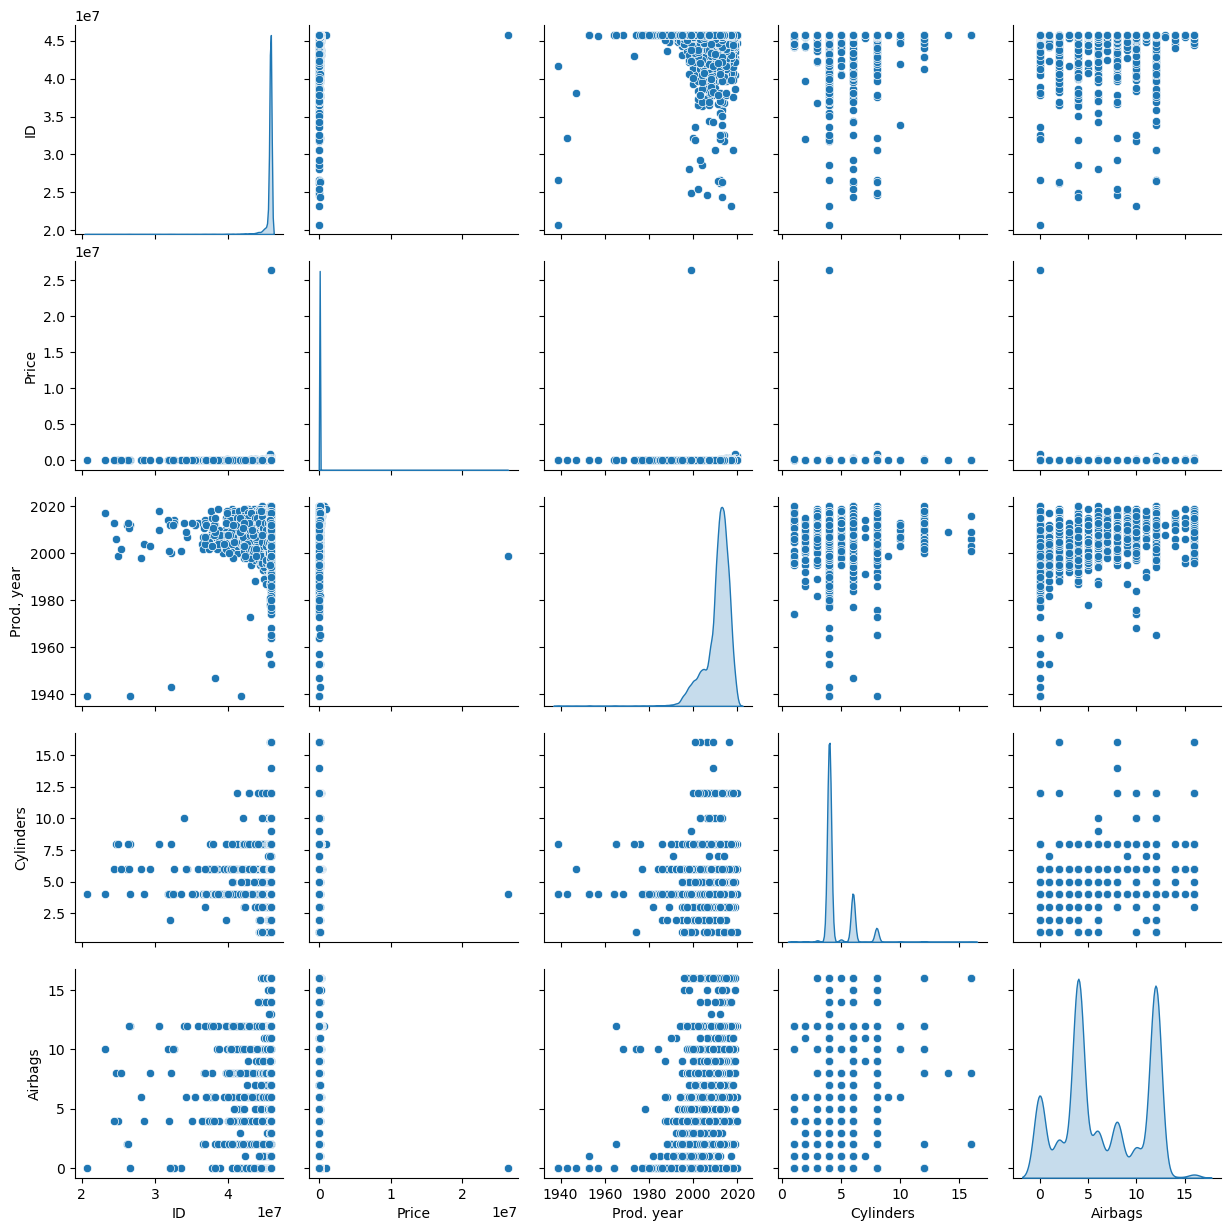

In [11]:
sns.pairplot(df, diag_kind='kde')

# Data Preparation


Here we will clean the data and prepare it for training the model.


‘ID’ column
We are dropping the ‘ID’ column since it does not hold any significance for car Price prediction.

In [12]:
df.drop('ID',axis=1,inplace=True)

‘Levy’ column
After analyzing the ‘Levy’ column we found out that it does contain the missing values but it was given as ‘-‘ in the data and that’s why we were not able to capture the missing values earlier in the data.
we will impute ‘-‘ in the ‘Levy’ column with ‘0’ assuming there was no ‘Levy’. We can also impute it with ‘mean’ or ‘median’

In [13]:
df['Levy']=df['Levy'].replace('-',np.nan)
df['Levy']=df['Levy'].astype(float)
levy_mean=0
df['Levy'].fillna(levy_mean,inplace=True)
df['Levy']=round(df['Levy'],2)

‘Mileage’ column
‘Mileage’ column here means how many kilometres the car has driven. ‘km’ is written in the column after each reading. We will remove that.


In [14]:
#since milage is in KM only we will remove 'km' from it and make it numerical
df['Mileage']=df['Mileage'].apply(lambda x:x.split(' ')[0])
df['Mileage']=df['Mileage'].astype('int')

‘Engine Volume’ column
In the ‘Engine Volumn’ column along with the Engine Volumn ‘type’ of the engine(Turbo or not Turbo) is also written. We will create a new column that shows the ‘type’ of ‘Engine’.


In [15]:
df['Turbo']=df['Engine volume'].apply(lambda x:1 if 'Turbo' in str(x) else 0)
df['Engine volume']=df['Engine volume'].apply(lambda x:str(x).replace('Turbo',''))
df['Engine volume']=df['Engine volume'].astype(float)

## Handling ‘Outliers’


In [19]:
#This we will examine across numerical features.

cols=['Levy','Engine volume', 'Mileage','Cylinders','Airbags']


There are outliers in ‘Levy’,’Engine volume’, ‘Mileage’, ‘Cylinders’ columns. We will remove these outliers using Inter Quantile Range(IQR) method.

In [20]:
def find_outliers_limit(df,col):
    print(col)
    print('-'*50)
    #removing outliers
    q25, q75 = np.percentile(df[col], 25), np.percentile(df[col], 75)
    iqr = q75 - q25
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    print('Lower:',lower,' Upper:',upper)
    return lower,upper

In [22]:
import numpy as np

def find_outliers_limit(df, col):
    # Calculate the IQR (Interquartile Range)
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return lower_bound, upper_bound

def remove_outlier(df, col, upper, lower):
    # Create a copy of the column
    final = df[col].copy()

    # Replace values above the upper bound with the upper bound
    final[final > upper] = upper

    # Replace values below the lower bound with the lower bound
    final[final < lower] = lower

    return final

# List of columns with potential outliers
outlier_cols = ['Levy', 'Engine volume', 'Mileage', 'Cylinders']

# Calculate and remove outliers for each column
for col in outlier_cols:
    lower, upper = find_outliers_limit(df, col)
    df[col] = remove_outlier(df, col, upper, lower)


<Axes: >

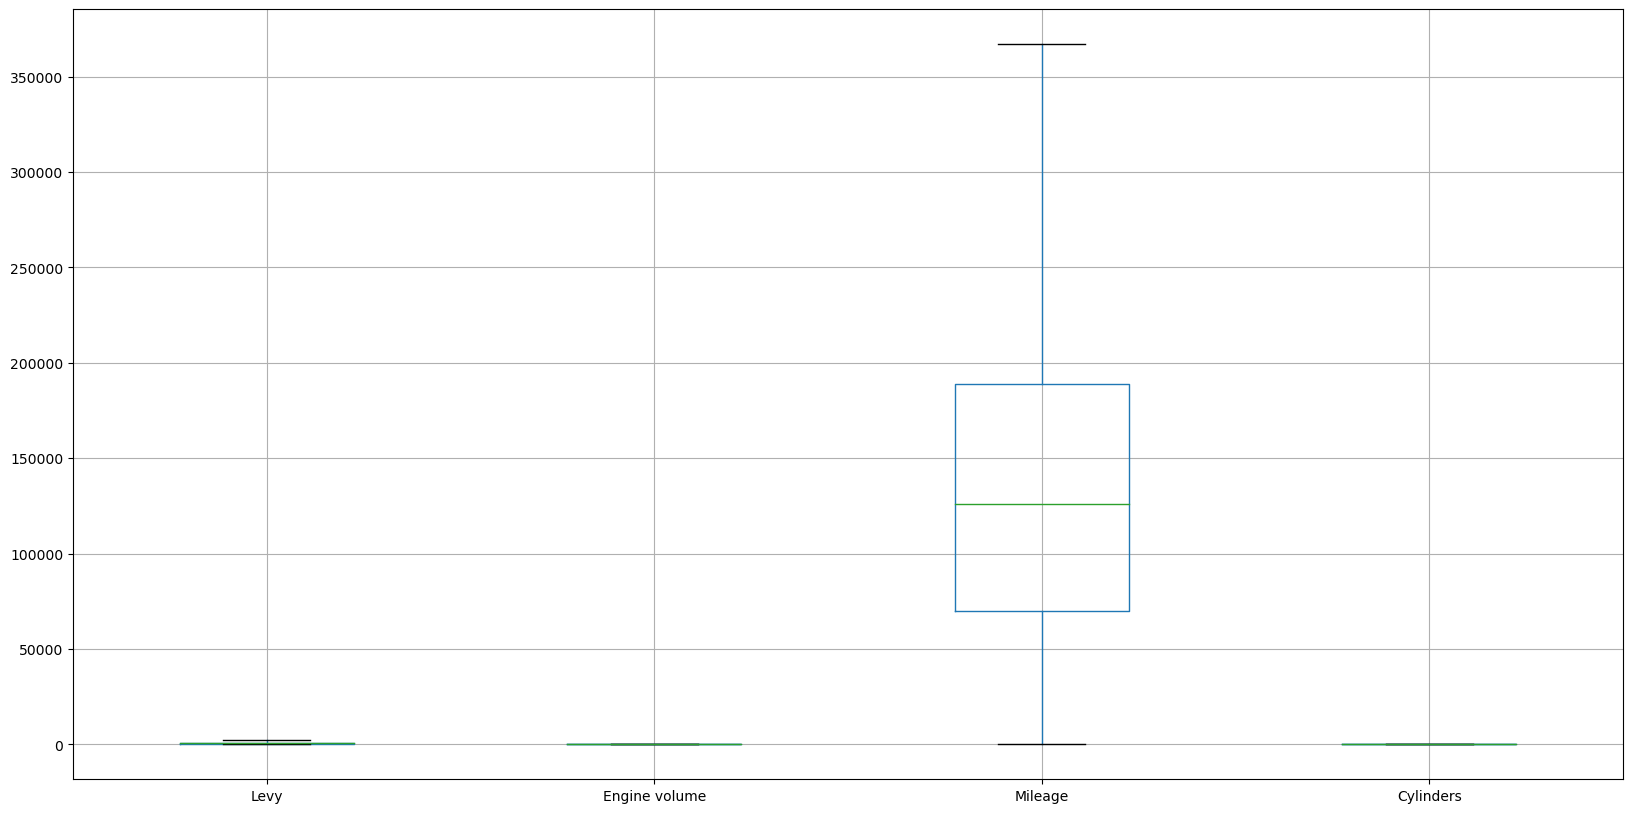

In [23]:
plt.figure(figsize=(20,10))
df[outlier_cols].boxplot()

## Creating Additional Features


We see that ‘Mileage’ and ‘Engine Volume’ are continuous variables. While performing regression I have observed that binning such variables can help increase the performance of the model. So I am creating the ‘Bin’ features for these features/columns.

In [24]:
labels=[0,1,2,3,4,5,6,7,8,9]
df['Mileage_bin']=pd.cut(df['Mileage'],len(labels),labels=labels)
df['Mileage_bin']=df['Mileage_bin'].astype(float)
labels=[0,1,2,3,4]
df['EV_bin']=pd.cut(df['Engine volume'],len(labels),labels=labels)
df['EV_bin']=df['EV_bin'].astype(float)

## Handling Categorical features

In [25]:
num_df=df.select_dtypes(include=np.number)

cat_df=df.select_dtypes(include=object)

encoding=OrdinalEncoder()

cat_cols=cat_df.columns.tolist()

encoding.fit(cat_df[cat_cols])

cat_oe=encoding.transform(cat_df[cat_cols])

cat_oe=pd.DataFrame(cat_oe,columns=cat_cols)

cat_df.reset_index(inplace=True,drop=True)

cat_oe.head()

,Manufacturer,Model,Category,Leather interior,Fuel type,Gear box type,Drive wheels,Doors,Wheel,Color
0,32.0,1242.0,4.0,1.0,2.0,0.0,0.0,1.0,0.0,12.0
1,8.0,658.0,4.0,0.0,5.0,2.0,0.0,1.0,0.0,1.0
2,21.0,684.0,3.0,0.0,5.0,3.0,1.0,1.0,1.0,1.0
3,16.0,661.0,4.0,1.0,2.0,0.0,0.0,1.0,0.0,14.0
4,21.0,684.0,3.0,1.0,5.0,0.0,1.0,1.0,0.0,12.0


In [28]:
num_df.reset_index(inplace=True,drop=True)

cat_oe.reset_index(inplace=True,drop=True)

final_all_df=pd.concat([num_df,cat_oe],axis=1)
final_all_df['price_log']=np.log(final_all_df['Price'])

# Data Splitting and Scaling

In [29]:
cols_drop=['Price','price_log','Cylinders']
X=final_all_df.drop(cols_drop,axis=1)
y=final_all_df['Price']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=25)
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

# Model Building

In [31]:
def train_ml_model(x,y,model_type):

    if model_type=='lr':

        model=LinearRegression()

    elif model_type=='xgb':

        model=XGBRegressor()

    elif model_type=='rf':

        model=RandomForestRegressor()

    model.fit(X_train_scaled,np.log(y))

    return model

In [32]:
def model_evaluate(model,x,y):

    predictions=model.predict(x)

    predictions=np.exp(predictions)

    mse=mean_squared_error(y,predictions)

    mae=mean_absolute_error(y,predictions)

    mape=mean_absolute_percentage_error(y,predictions)

    msle=mean_squared_log_error(y,predictions)

    mse=round(mse,2)

    mae=round(mae,2)

    mape=round(mape,2)

    msle=round(msle,2)

    return [mse,mae,mape,msle]

In [33]:
model_lr=train_ml_model(X_train_scaled,y_train,'lr')

model_xgb=train_ml_model(X_train_scaled,y_train,'xgb')

model_rf=train_ml_model(X_train_scaled,y_train,'rf')

#  Deep Learning

## Small Network


In [35]:
model_dl_small=Sequential()

model_dl_small.add(Dense(16,input_dim=X_train_scaled.shape[1],activation='relu'))

model_dl_small.add(Dense(8,activation='relu'))

model_dl_small.add(Dense(4,activation='relu'))

model_dl_small.add(Dense(1,activation='linear'))

model_dl_small.compile(loss='mean_squared_error',optimizer='adam')

model_dl_small.summary()

epochs=20

batch_size=10
model_dl_small.fit(X_train_scaled,np.log(y_train),verbose=0,validation_data=(X_test_scaled,np.log(y_test)),epochs=epochs,batch_size=batch_size)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                304       
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dense_6 (Dense)             (None, 4)                 36        
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                                                                 
Total params: 481 (1.88 KB)
Trainable params: 481 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## plot the loss and validation loss of the dataset 

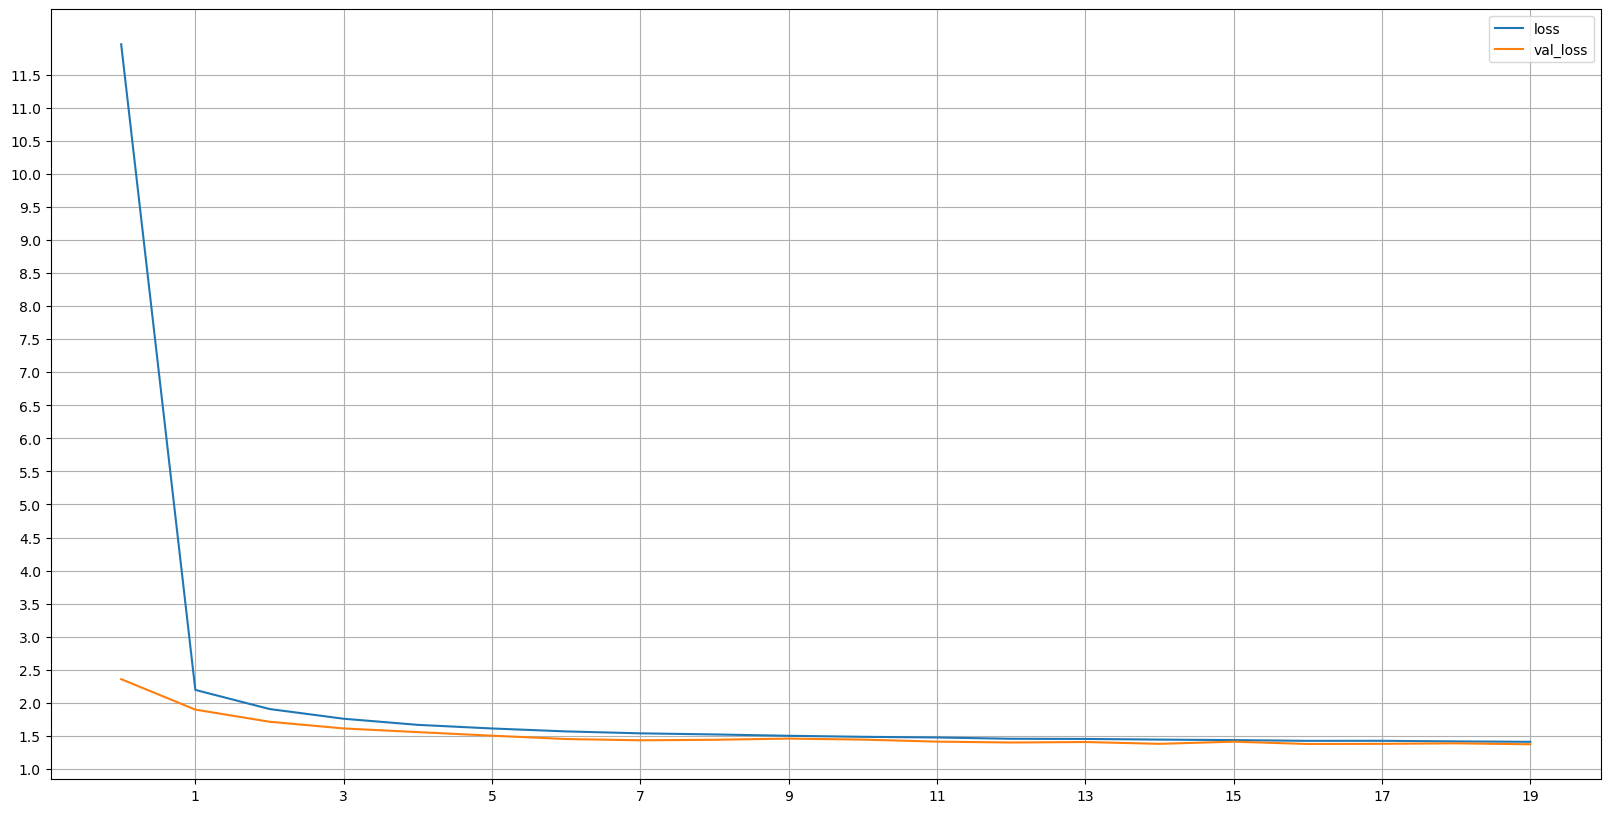

In [37]:
history_df = pd.DataFrame(model_dl_small.history.history)

plt.figure(figsize=(20,10))

plt.plot(history_df['loss'], label='loss')

plt.plot(history_df['val_loss'], label='val_loss')

plt.xticks(np.arange(1,epochs+1,2))

plt.yticks(np.arange(1,max(history_df['loss']),0.5))

plt.legend()

plt.grid()
plt.show()

## Large Network


In [38]:

model_dl_large=Sequential()

model_dl_large.add(Dense(64,input_dim=X_train_scaled.shape[1],activation='relu'))

model_dl_large.add(Dense(32,activation='relu'))

model_dl_large.add(Dense(16,activation='relu'))

model_dl_large.add(Dense(1,activation='linear'))

model_dl_large.compile(loss='mean_squared_error',optimizer='adam')

model_dl_large.summary()

epochs=20

batch_size=10

model_dl_large.fit(X_train_scaled,np.log(y_train),verbose=0,validation_data=(X_test_scaled,np.log(y_test)),epochs=epochs,batch_size=batch_size)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                1216      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3841 (15.00 KB)
Trainable params: 3841 (15.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## plot the loss and validation loss of the dataset

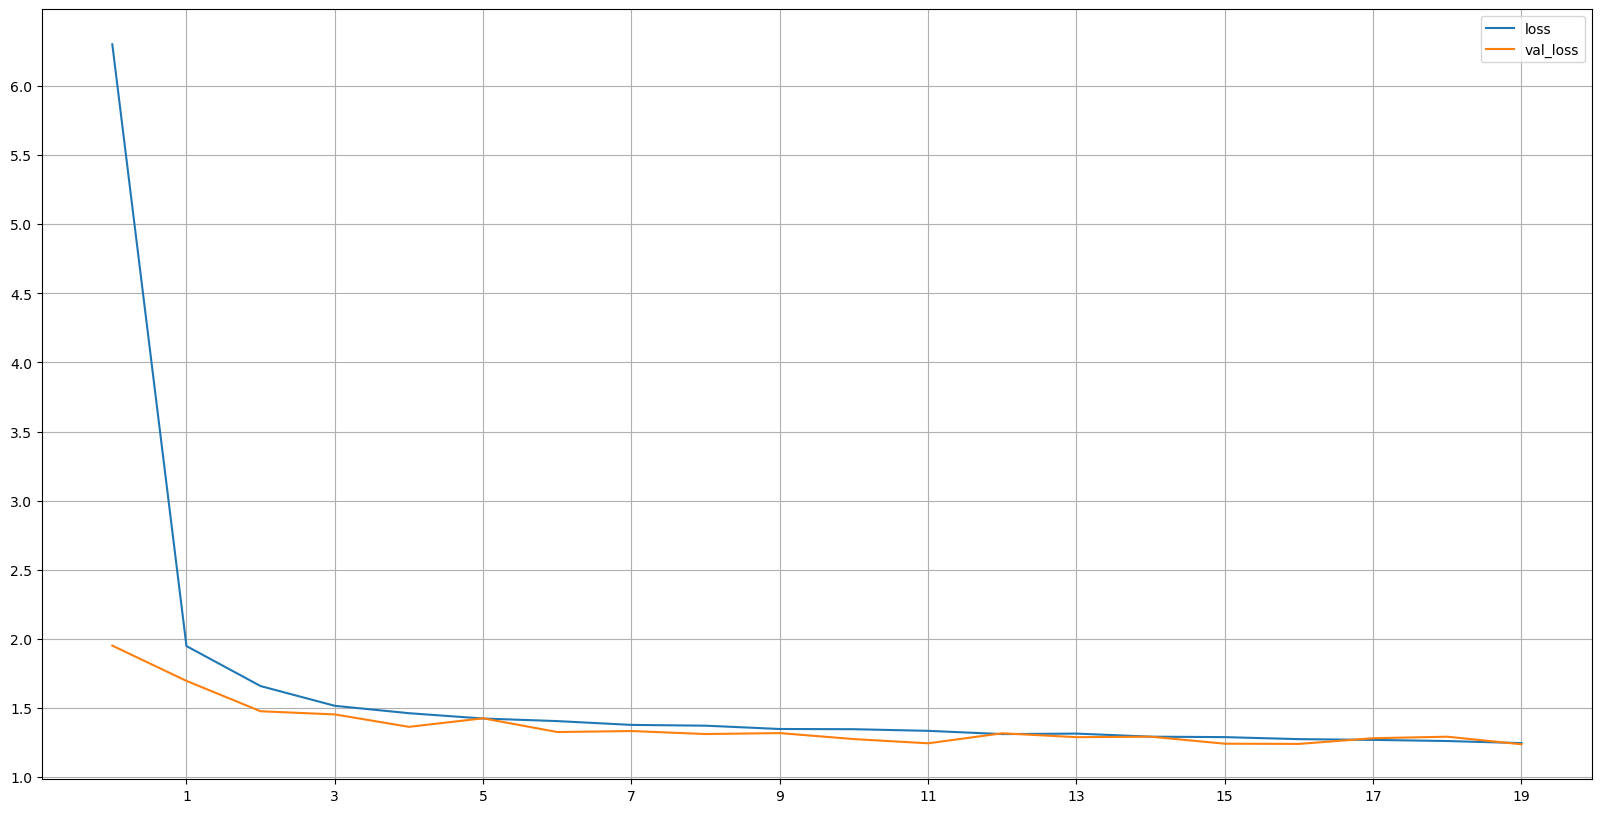

In [39]:
history_df = pd.DataFrame(model_dl_large.history.history)

plt.figure(figsize=(20,10))

plt.plot(history_df['loss'], label='loss')

plt.plot(history_df['val_loss'], label='val_loss')

plt.xticks(np.arange(1,epochs+1,2))

plt.yticks(np.arange(1,max(history_df['loss']),0.5))

plt.legend()

plt.grid()
plt.show()



In [40]:
summary=PrettyTable(['Model','MSE','MAE','MAPE','MSLE'])

summary.add_row(['LR']+model_evaluate(model_lr,X_test_scaled,y_test))

summary.add_row(['XGB']+model_evaluate(model_xgb,X_test_scaled,y_test))

summary.add_row(['RF']+model_evaluate(model_rf,X_test_scaled,y_test))

summary.add_row(['DL_SMALL']+model_evaluate(model_dl_small,X_test_scaled,y_test))

summary.add_row(['DL_LARGE']+model_evaluate(model_dl_large,X_test_scaled,y_test))

print(summary)



121/121 [==============================] - 2s 10ms/step
+----------+--------------+----------+------+------+
|  Model   |     MSE      |   MAE    | MAPE | MSLE |
+----------+--------------+----------+------+------+
|    LR    | 337217465.57 | 11117.14 | 6.88 | 2.04 |
|   XGB    | 176216323.34 | 6106.17  | 3.29 | 0.85 |
|    RF    | 107554134.75 | 4580.26  | 3.11 | 0.79 |
| DL_SMALL | 218091661.8  | 7841.99  | 4.71 | 1.37 |
| DL_LARGE | 175524572.49 | 7151.71  | 4.56 | 1.23 |
+----------+--------------+----------+------+------+


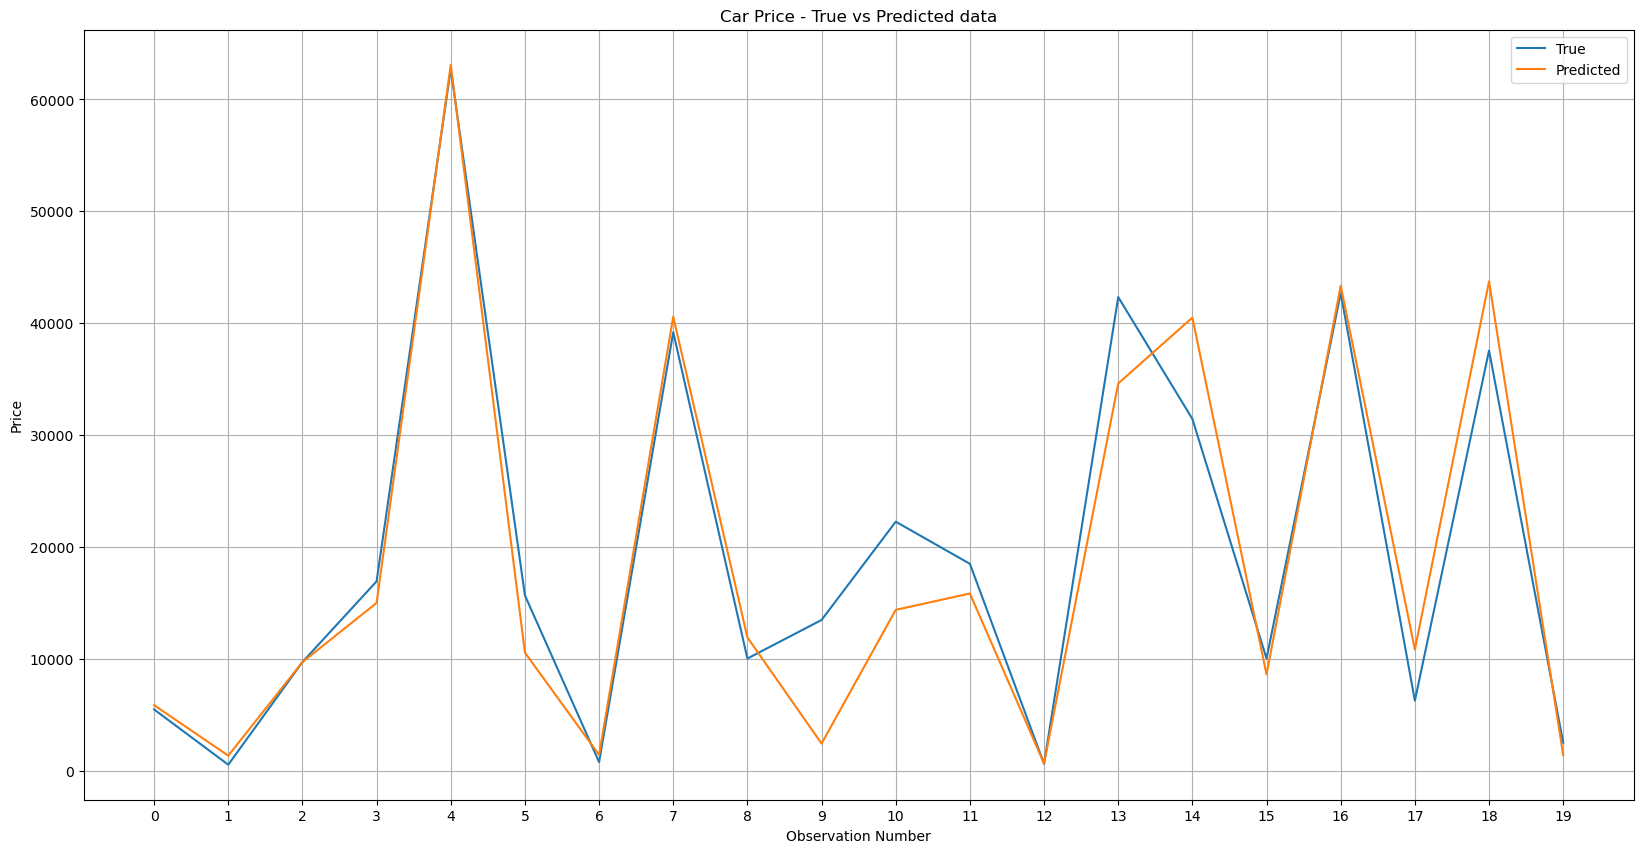

In [41]:
y_pred=np.exp(model_rf.predict(X_test_scaled))

number_of_observations=20

x_ax = range(len(y_test[:number_of_observations]))

plt.figure(figsize=(20,10))

plt.plot(x_ax, y_test[:number_of_observations], label="True")

plt.plot(x_ax, y_pred[:number_of_observations], label="Predicted")

plt.title("Car Price - True vs Predicted data")

plt.xlabel('Observation Number')

plt.ylabel('Price')

plt.xticks(np.arange(number_of_observations))

plt.legend()

plt.grid()

plt.show()

In [42]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

def finding_the_best_ml_model(x, y):
    algos = {
        "linear regression": {
            "model": LinearRegression(),
            "params": {
                "fit_intercept": [True, False],
                "copy_X": [True, False]
            }
        },
        "lasso": {
            "model": Lasso(),
            "params": {
                "alpha": [1, 2],
                "selection": ["random", "cyclic"]
            }
        },
        "decision tree": {
            "model": DecisionTreeRegressor(),
            "params": {
                "criterion": ["mse", "friedman_mse"],
                "splitter": ["best", "random"]
            }
        },
        "random forest": {
            "model": RandomForestRegressor(),
            "params": {
                "n_estimators": [100, 200, 300],
                "max_depth": [None, 10, 20, 30],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4]
            }
        },
        "xgboost": {
            "model": XGBRegressor(),
            "params": {
                "n_estimators": [100, 200, 300],
                "learning_rate": [0.01, 0.1, 0.2],
                "max_depth": [3, 4, 5],
                "min_child_weight": [1, 2, 3]
            }
        }
    }
    
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(x, y)
        
        scores.append({
            "model": algo_name,
            "best_score": gs.best_score_,
            "best_params": gs.best_params_
        })
    
    return pd.DataFrame(scores, columns=["model", "best_score", "best_params"])


In [ ]:
 finding_the_best_ml_model(X, y)

C:\Users\OWNER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.575e+14, tolerance: 6.972e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\OWNER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.473e+14, tolerance: 6.973e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\OWNER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.756e+11, toleranc